# Modeling

In [1]:
# ─── Cell 1: Setup & Imports ───────────────────────────────────────────────────
import logging
import os
import joblib       # for saving scikit‑learn models
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import layers, models

def setup_logging():
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s [%(levelname)s] %(message)s",
        datefmt="%H:%M:%S"
    )

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

setup_logging()

# Load engineered data
df = pd.read_csv("../data/processed/engineered_data.csv")

# Features & target
X = df.drop(columns=["GradeClass"])
y = df["GradeClass"]



#### Train-Test Split (80/20)

In [2]:
# Train/test split (80/20 stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
logging.info(f"Data shapes — X_train: {X_train.shape}, X_test: {X_test.shape}")

19:38:56 [INFO] Data shapes — X_train: (1913, 12), X_test: (479, 12)


## Evaluation Metrics

In [3]:
def evaluate_and_save(model, name, X_train, X_test, y_train, y_test, artifacts_dir="artifacts"):
    """
    Trains `model`, evaluates, plots a normalized confusion matrix heatmap,
    and then saves the trained model to artifacts_dir/name.joblib.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

    # 1) Fit & predict
    logging.info(f"Training & evaluating {name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # 2) Print metrics
    acc = accuracy_score(y_test, preds)
    logging.info(f"{name} Accuracy: {acc:.3f}")
    print(f"\n=== {name} Classification Report ===")
    print(classification_report(y_test, preds, zero_division=0))

    # 3) Confusion matrix
    cm = confusion_matrix(y_test, preds)
    # 4) Plot normalized confusion matrix heatmap
    cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm_norm,
        annot=cm,
        fmt='d',
        cmap='Blues',
        linewidths=0.5,
        linecolor='gray',
        xticklabels=np.unique(y_test),
        yticklabels=np.unique(y_test)
    )
    plt.title(f"{name} Confusion Matrix\n(colors=normalized, numbers=counts)")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # 5) Save the trained model
    ensure_dir(artifacts_dir)
    filepath = os.path.join(artifacts_dir, f"{name}.joblib")
    joblib.dump(model, filepath)
    logging.info(f"Saved {name} to {filepath}\n")


## Model Building: Part 1 (Baseline ML Models)

## Baseline ML Models

19:38:56 [INFO] Training & evaluating LogisticRegression
c:\Users\jerem\OneDrive\Desktop\BrightPath-Grade-Predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
19:38:56 [INFO] LogisticRegression Accuracy: 0.760



=== LogisticRegression Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.33      0.50        15
           1       0.61      0.47      0.53        49
           2       0.53      0.77      0.62        77
           3       0.63      0.31      0.42        83
           4       0.89      0.98      0.93       255

    accuracy                           0.76       479
   macro avg       0.73      0.57      0.60       479
weighted avg       0.76      0.76      0.74       479



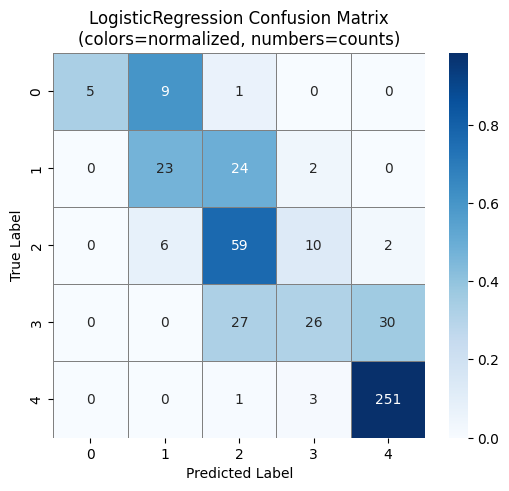

19:38:57 [INFO] Saved LogisticRegression to artifacts\LogisticRegression.joblib

19:38:57 [INFO] Training & evaluating RandomForestClassifier
19:38:57 [INFO] RandomForestClassifier Accuracy: 0.768



=== RandomForestClassifier Classification Report ===
              precision    recall  f1-score   support

           0       0.50      0.33      0.40        15
           1       0.61      0.57      0.59        49
           2       0.61      0.65      0.63        77
           3       0.56      0.64      0.60        83
           4       0.94      0.91      0.92       255

    accuracy                           0.77       479
   macro avg       0.64      0.62      0.63       479
weighted avg       0.77      0.77      0.77       479



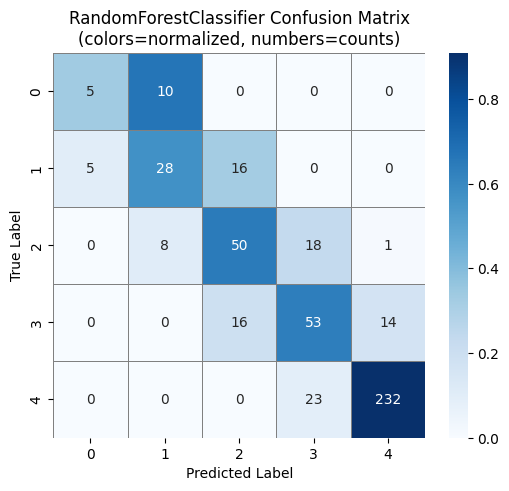

19:38:57 [INFO] Saved RandomForestClassifier to artifacts\RandomForestClassifier.joblib

19:38:57 [INFO] Training & evaluating XGBClassifier
c:\Users\jerem\OneDrive\Desktop\BrightPath-Grade-Predictor\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:38:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
19:38:57 [INFO] XGBClassifier Accuracy: 0.779



=== XGBClassifier Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.27      0.42        15
           1       0.62      0.67      0.65        49
           2       0.60      0.65      0.62        77
           3       0.58      0.59      0.58        83
           4       0.94      0.93      0.93       255

    accuracy                           0.78       479
   macro avg       0.75      0.62      0.64       479
weighted avg       0.79      0.78      0.78       479



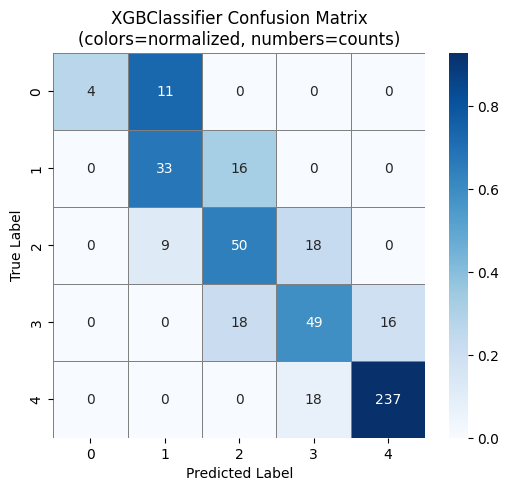

19:38:58 [INFO] Saved XGBClassifier to artifacts\XGBClassifier.joblib



In [4]:
# ─── Cell 4: Train & Save Baseline Classifiers ───────────────────────────────
model_defs = {
    "LogisticRegression": LogisticRegression(
        C=1.0, solver="liblinear", multi_class="ovr", max_iter=500, random_state=42
    ),
    "RandomForestClassifier": RandomForestClassifier(
        n_estimators=200, max_depth=12, class_weight="balanced", random_state=42
    ),
    "XGBClassifier": XGBClassifier(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        eval_metric="mlogloss",
        use_label_encoder=False,
        random_state=42
    )
}

for name, mdl in model_defs.items():
    evaluate_and_save(mdl, name, X_train, X_test, y_train, y_test)


## Random Forest Regressor

19:41:21 [INFO] Training & evaluating RandomForestRegressor
19:41:21 [INFO] RandomForestRegressor→Classifier Accuracy: 0.785


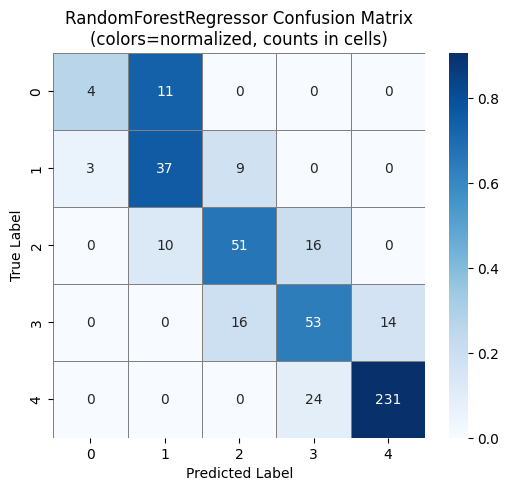

19:41:22 [INFO] Saved RandomForestRegressor to artifacts/RandomForestRegressor.joblib


In [7]:
# ─── Cell: Random Forest Regressor (Rounded) & Heatmap ───────────────────────
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix

name = "RandomForestRegressor"
logging.info(f"Training & evaluating {name}")

# 1) Train regressor
rf_reg = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
rf_reg.fit(X_train, y_train)

# 2) Predict & round to nearest class
preds_reg = np.round(rf_reg.predict(X_test)).astype(int)

# 3) Accuracy
acc = accuracy_score(y_test, preds_reg)
logging.info(f"{name}→Classifier Accuracy: {acc:.3f}")

# 4) Confusion matrix heatmap (normalized colors + raw counts)
cm = confusion_matrix(y_test, preds_reg)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_norm,
    annot=cm,
    fmt='d',
    cmap='Blues',
    linewidths=0.5,
    linecolor='gray',
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test)
)
plt.title(f"{name} Confusion Matrix\n(colors=normalized, counts in cells)")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 5) Save the trained regressor
ensure_dir("artifacts")
joblib.dump(rf_reg, f"artifacts/{name}.joblib")
logging.info(f"Saved {name} to artifacts/{name}.joblib") 


## Model Building: Part 2 (Deep Learning Model) (Step 10)
#### 🧠 Deep Learning Model: Neural Network

We will now train a feedforward neural network to classify students into GradeClass labels (A–F), using TensorFlow/Keras.


In [ ]:
# ─── Cell: Deep Learning MLP & Heatmap ───────────────────────────────────────
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

name = "DeepLearningMLP"
logging.info(f"Building & training {name}")

# Build & compile
num_features = X_train.shape[1]
num_classes = y_train.nunique()
dl = models.Sequential([
    layers.Input(shape=(num_features,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")
])
dl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train
history = dl.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=25,
    batch_size=32,
    verbose=1
)

# Evaluate
loss, acc = dl.evaluate(X_test, y_test, verbose=0)
logging.info(f"{name} Test Accuracy: {acc:.3f}")

# Predict & round
probs = dl.predict(X_test)
y_pred = np.argmax(probs, axis=1)

# Classification report
print(f"\n=== {name} Classification Report ===")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_norm,
    annot=cm,
    fmt='d',
    cmap='Blues',
    linewidths=0.5,
    linecolor='gray',
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test)
)
plt.title(f"{name} Confusion Matrix\n(colors=normalized, counts in cells)")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save the model
ensure_dir("artifacts")
save_path = os.path.join("artifacts", f"{name}.keras")
dl.save(save_path)
logging.info(f"Saved {name} to {save_path}")


19:38:58 [INFO] Building & training DeepLearningMLP


Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5476 - loss: 1.4854 - val_accuracy: 0.6927 - val_loss: 0.6497
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6287 - loss: 0.8284 - val_accuracy: 0.7396 - val_loss: 0.6193
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6863 - loss: 0.7103 - val_accuracy: 0.7500 - val_loss: 0.5883
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6932 - loss: 0.6649 - val_accuracy: 0.7865 - val_loss: 0.5481
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7066 - loss: 0.6414 - val_accuracy: 0.7760 - val_loss: 0.5331
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7256 - loss: 0.5770 - val_accuracy: 0.7760 - val_loss: 0.4963
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7381 - loss: 0.5824 - val_accuracy: 0.8177 - val_loss: 0.4873
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7266 - loss: 0.5682 - val_accuracy: 0.8021 - val_loss:

19:39:04 [INFO] DeepLearningMLP Test Accuracy: 0.793


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


19:39:05 [INFO] Saved DeepLearningMLP to artifacts\DeepLearningMLP.keras




=== DeepLearningMLP Confusion Matrix ===
[[ 10   5   0   0   0]
 [ 10  29  10   0   0]
 [  0  13  51  13   0]
 [  0   0  17  50  16]
 [  0   0   0  15 240]]

=== DeepLearningMLP Classification Report ===
              precision    recall  f1-score   support

           0       0.50      0.67      0.57        15
           1       0.62      0.59      0.60        49
           2       0.65      0.66      0.66        77
           3       0.64      0.60      0.62        83
           4       0.94      0.94      0.94       255

    accuracy                           0.79       479
   macro avg       0.67      0.69      0.68       479
weighted avg       0.79      0.79      0.79       479

